In [2]:
import matplotlib.pyplot as plot
import geopandas as gpd
import earthpy as et
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

plt.style.use('seaborn-darkgrid')

In [3]:
data = pd.read_csv("1976-2018-house2.csv", encoding="latin1")

In [4]:
# First 5 rows
data.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,runoff,special,candidate,party,writein,mode,candidatevotes,totalvotes,unofficial,version
0,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,Bill Davenport,democrat,False,total,58906,157170,False,20200424
1,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,Jack Edwards,republican,False,total,98257,157170,False,20200424
2,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,NaN,NaN,True,total,7,157170,False,20200424
3,1976,Alabama,AL,1,63,41,US House,2,gen,False,False,J. Carole Keahey,democrat,False,total,66288,156362,False,20200424
4,1976,Alabama,AL,1,63,41,US House,2,gen,False,False,NaN,NaN,True,total,5,156362,False,20200424


# Vote Counts: Columns

year: year in which election was held

state: state name

description: state abbreviation

state_fips: numeric state code

state_cen: US census state code

state_ic: ICPSR state code

office: U.S. House (constant)

district: District number. At-large districts are coded as 0

stage: electoral stage ("gen" = general, "pri" = primary)

special: special election boolean (True = special election, False = regular election

candidate: name of candidate

party: party of candidate 

writein: boolean write in candidate (true = write-in, false = not write-in)

mode: mode of voting

candidatevotes: # of votes received by this candidate for this party

totalvates: total number of votes cast for this election

unofficial: boolean True/False (true = unofficial result)

version: date when this dataset was finalized

In [5]:
# This cell produces two dataframes.
# One is vote counts by state.
# The other is vote counts by district.

# Count only states with more than 3 districts.
def over_3_districts(state, df):
    if len(df.loc[state,:]) > 3:
        return True
    return False

# Group by district and list total democrat and republican votes.
# This gives us a dataframe of vote counts grouped by district.
def groupDistricts(df, party):
    party_votes = df.loc[df["party"] == party]
    party_votes = party_votes.loc[:, ["state", "district", "candidatevotes"]]
    party_votes = party_votes.groupby(by=["state", "district"]).sum()
    return party_votes

def get_vote_counts_bystate(df, year):
    data_year = data[data["year"] == year]
    data_year = data_year[["party", "state", "candidatevotes"]]
    
    demOnly = np.array(data_year["party"] == "democrat")
    repOnly = np.array(data_year["party"] == "republican")
    demVotes = data_year[demOnly].groupby(["state"]).sum()
    repVotes = data_year[repOnly].groupby(["state"]).sum()
    
    # Rename columns to get ready to join our dataframes.
    demVotes = demVotes.rename(columns={"candidatevotes": "dem_votes"})
    repVotes = repVotes.rename(columns={"candidatevotes": "rep_votes"})
    
    # Join on all states that have votes by both parties.
    vote_counts_bystate = demVotes.join(repVotes, how="inner")
    return vote_counts_bystate


def get_vote_counts_bydistrict(df, year):
    df = df[df["year"] == year]
    dem_votes = groupDistricts(df, "democrat")
    rep_votes = groupDistricts(df, "republican")
    dem_votes = dem_votes.rename(columns={"candidatevotes": "dem_votes"})
    rep_votes = rep_votes.rename(columns={"candidatevotes": "rep_votes"})
    vote_counts_bydistrict = dem_votes.join(rep_votes, how="outer")
    
    # Slice out vote states with <3 districts.
    state_set = set()  
    for index in vote_counts_bydistrict.index:
        state, districts = index
        if over_3_districts(state, vote_counts_bydistrict):
            state_set.add(state)
    vote_counts_bydistrict = vote_counts_bydistrict.loc[state_set, :]
    
    # Come up with the winners for each district.
    vote_counts_bydistrict["winner"] = vote_counts_bydistrict["dem_votes"] >= vote_counts_bydistrict["rep_votes"]
    vote_counts_bydistrict["winner"] = vote_counts_bydistrict["winner"].apply(lambda win_bool: "d" if win_bool else "r")

    # Some races had no democrat or republican candidate.
    # These can be seen in NaN columns.
    # Drop these.
    vote_counts_bydistrict = vote_counts_bydistrict.dropna()

    # Come up with the winners for the above dataframe.
    # Come up with the winners for the above dataframe.
    vote_counts_bydistrict["winner"] = vote_counts_bydistrict["dem_votes"] >= vote_counts_bydistrict["rep_votes"]
    vote_counts_bydistrict["winner"] = vote_counts_bydistrict["winner"].apply(lambda win_bool: "d" if win_bool else "r")
    
    return vote_counts_bydistrict

vote_counts_bydistrict = get_vote_counts_bydistrict(data, 2018)
vote_counts_bystate = vote_counts_bydistrict.groupby("state").sum()

# Data Wrangling and Cleaning

Because we needed to work with vote counts by both state and district, we had to get our data into a form that would make it easy for us to work with. We began with the raw dataframe, which includes total votes for individual candidates by district. We also began with vote returns for all years. We decided to focus only on 2018, so we slices the data down to vote counts per districts, determined winners for districts and inserted those into columns, and dropped null values. We organized vote returns by district, by state, in a 2 dimensional dataframe. We also created a second dataframe for vote returns by state, which is simple the vote counts by district and state aggregated into vote counts by state--i.e. a rollup operation performed on district to aggregate votes by state.


Furthermore, we placed our gerrymandering metrics per state values as columns in a new dataframe.


In [379]:
# Raw data
data.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,runoff,special,candidate,party,writein,mode,candidatevotes,totalvotes,unofficial,version
0,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,Bill Davenport,democrat,False,total,58906,157170,False,20200424
1,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,Jack Edwards,republican,False,total,98257,157170,False,20200424
2,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,NaN,NaN,True,total,7,157170,False,20200424
3,1976,Alabama,AL,1,63,41,US House,2,gen,False,False,J. Carole Keahey,democrat,False,total,66288,156362,False,20200424
4,1976,Alabama,AL,1,63,41,US House,2,gen,False,False,NaN,NaN,True,total,5,156362,False,20200424


In [382]:
# Cleaned data by district
vote_counts_bydistrict

dem_votes  rep_votes winner  wasted_republican  \
state     district                                                   
Oregon    1          231198.0   116446.0      d           116446.0   
          2          145298.0   207597.0      r            31148.5   
          3          279019.0    76187.0      d            76187.0   
          4          208710.0   152414.0      d           152414.0   
          5          197187.0   149887.0      d           149887.0   
...                       ...        ...    ...                ...   
Wisconsin 4          206487.0    59091.0      d            59091.0   
          5          138385.0   225619.0      r            43616.0   
          6          144536.0   180311.0      r            17886.5   
          7          124307.0   194061.0      r            34876.0   
          8          119265.0   209410.0      r            45071.5   

                    wasted_democrat  
state     district                   
Oregon    1                 57375.0  
          2                145298.0  
          3                101415.0  
          4                 28147.0  
          5                 23649.0  
...                             ...  
Wisconsin 4                 73697.0  
          5                138385.0  
          6                144536.0  
          7                124307.0  
          8                119265.0  

[360 rows x 5 columns]

In [383]:
# Cleaned data by state
vote_counts_bystate

,dem_votes,rep_votes,e_gap,district,num_districts,mm_diff_against_dem,mm_diff_against_rep,partisan_bias_against_dem,partisan_bias_against_rep
state,,,,,,,,,
Alabama,493677.0,975737.0,0.171941,NaN,6,-0.029543,0.029543,-0.166667,0.166667
Arizona,1066149.0,1139251.0,0.013026,NaN,8,-0.000284,0.000284,0.000000,0.000000
Arkansas,312978.0,556339.0,0.220060,NaN,4,0.027093,-0.027093,0.250000,-0.250000
California,6608298.0,3802611.0,-0.081420,NaN,44,-0.008178,0.008178,0.045455,-0.045455
Colorado,1343211.0,1079772.0,0.021465,NaN,7,-0.007600,0.007600,-0.071429,0.071429
Connecticut,808652.0,512495.0,-0.275837,NaN,5,-0.008802,0.008802,-0.300000,0.300000
Florida,3104569.0,3675417.0,0.085129,NaN,22,0.018385,-0.018385,0.090909,-0.090909
Georgia,1539063.0,1789039.0,0.085985,NaN,12,0.045823,-0.045823,0.083333,-0.083333
Illinois,2757540.0,1754449.0,0.016514,NaN,18,-0.024519,0.024519,-0.055556,0.055556


In [390]:
# After calculated gerrymandering metrics
vote_counts_bystate_sorted.head()

,dem_votes,rep_votes,e_gap,num_districts,mm_diff_against_dem,mm_diff_against_rep,partisan_bias_against_dem,partisan_bias_against_rep,gerry_metrics_mean
state,,,,,,,,,
Mississippi,239849.0,471162.0,0.174675,3,0.009706,-0.009706,0.166667,-0.166667,0.117016
Utah,374009.0,617307.0,-0.017020,4,0.022921,-0.022921,0.000000,0.000000,0.001967
Arkansas,312978.0,556339.0,0.220060,4,0.027093,-0.027093,0.250000,-0.250000,0.165718
Nevada,491272.0,439727.0,-0.135789,4,0.002251,-0.002251,-0.250000,0.250000,-0.127846
Iowa,664676.0,612338.0,-0.220240,4,0.002048,-0.002048,0.000000,0.000000,-0.072731


In [10]:
# Calculate the wasted votes for each district.
def wasted_winner(total_votes_winner, district_vote_total):
    # Votes needed to win: 1 + (total votes / 2) 
    votes_needed = (district_vote_total / 2) + 1
    return total_votes_winner - (votes_needed)

def get_efficiency_gap(dem_votes, rep_votes, wasted_dem, wasted_rep):
    return (wasted_dem - wasted_rep) / (dem_votes + rep_votes)

def calculate_wasted_votes(df_district):
    """
        Takes the "by district"
        dataframe, calculates efficiency gap,
        places it into a column in the "by state"
        efficiency
    """
    dem_votes = np.array(df_district["dem_votes"])
    rep_votes = np.array(df_district["rep_votes"])
    rep_winner = np.array(df_district["dem_votes"] < df_district["rep_votes"])
    total_votes = dem_votes + rep_votes
    wasted_votes_dem = np.zeros(len(rep_winner))
    wasted_votes_rep = np.zeros(len(rep_winner))
    for i in range(len(rep_winner)):
        if rep_winner[i]:
            wasted_votes_rep[i] = wasted_winner(rep_votes[i], total_votes[i])
            wasted_votes_dem[i] = dem_votes[i]
        else:
            wasted_votes_dem[i] = wasted_winner(dem_votes[i], total_votes[i])
            wasted_votes_rep[i] = rep_votes[i]
    return wasted_votes_rep, wasted_votes_dem

# Simulating Gerrymandering Metric Distributions


In [287]:
import random

def get_pb(dem_votes, rep_votes):
    # Takes arrays of votes per district
    dem_votes_total = np.sum(dem_votes)
    rep_votes_total = np.sum(rep_votes)
    num_districts = len(dem_votes)
    vote_total_state = np.sum([dem_votes, rep_votes])
    dem_votes_tied = dem_votes - (get_vote_diff(vote_total_state, dem_votes_total, .5, num_districts)) 
    rep_votes_tied = rep_votes - (get_vote_diff(vote_total_state,  rep_votes_total, .5, num_districts))
    rep_won_districts = np.sum(np.greater(rep_votes_tied, dem_votes_tied))
    dem_won_districts = np.sum(np.greater(dem_votes_tied, rep_votes_tied))
    rep_won_percent = rep_won_districts / num_districts
    dem_won_percent = dem_won_districts / num_districts
    partisan_bias_against_dem = rep_won_percent - 0.5
    partisan_bias_against_rep = dem_won_percent - 0.5
    return partisan_bias_against_dem, partisan_bias_against_rep

def get_mm(dem_votes_district, rep_votes_district):
    # This cell performs the calculation of mean-median difference.
    total_votes = dem_votes_district + rep_votes_district
    dem_voteshare = dem_votes_district / total_votes
    rep_voteshare = rep_votes_district / total_votes

    total_dem_voteshare = np.sum(dem_voteshare)
    total_districts = len(dem_voteshare)
    dem_district_median = np.median(dem_voteshare)
    dem_mean_share = total_dem_voteshare / total_districts

    total_rep_voteshare = np.sum(rep_voteshare)
    rep_district_median = np.median(rep_voteshare)
    rep_mean_share = total_rep_voteshare / total_districts

    mm_diff_against_dem = dem_mean_share - dem_district_median
    mm_diff_against_rep = rep_mean_share - rep_district_median

    return mm_diff_against_dem, mm_diff_against_rep


def simulate_elections(num_districts, num_voters, num_simulations):
    e_gap_values = []
    
    mm_diff_against_dem = []
    mm_diff_against_rep = []
    pb_against_dem = []
    pb_against_rep = []
    
    for i in range(num_simulations):
        vote_counts_simulate = pd.DataFrame()
        total_votes = 10000
        
        # Random voting proportions per district
        random_district_proportions = []
        
        # Continually decrement proportions and
        # assign the last one to the last district
        remaining_proportion = 1 
        
        # Generate random voting proportions per district
        for i in range(len(vote_counts_simulate) - 1):
            random_sample = random.uniform(0, remaining_proportion)
            random_district_proportions.append(random_sample)
            remaining_proportion -= random_sample
        
        # Fill in the proportions list with proportions
        random_district_proportions.append(remaining_proportion)
        random_district_proportions = np.array(random_district_proportions)
        
        district_totals = total_votes * random_district_proportions
        random_democrat_proportion = []
        
        for i in range(num_districts):
            random_democrat_proportion.append(random.uniform(0, 1))

        dem_votes_random = district_totals * random_democrat_proportion
        rep_votes_random = district_totals - dem_votes_random

        vote_counts_simulate["dem_votes"] = dem_votes_random
        vote_counts_simulate["rep_votes"] = rep_votes_random
        wasted_dem_random, wasted_rep_random = calculate_wasted_votes(vote_counts_simulate)
        
        wasted_dem_state = np.sum(wasted_dem_random)
        wasted_rep_state = np.sum(wasted_rep_random)
        
        dem_state_votes = np.sum(dem_votes_random)
        rep_state_votes = np.sum(rep_votes_random)
        
        e_gap = get_efficiency_gap(dem_state_votes, rep_state_votes, wasted_dem_state, wasted_rep_state)
        mm_single_dem, mm_single_rep = get_mm(dem_votes_random, rep_votes_random)
        pb_against_dem_state, pb_against_rep_state = get_pb(dem_votes_random, rep_votes_random)
        pb_against_dem.append(pb_against_dem_state)
        pb_against_rep.append(pb_against_rep_state)
        mm_diff_against_dem.append(mm_single_dem)
        mm_diff_against_rep.append(mm_single_rep)
        e_gap_values.append(e_gap)
        
    return e_gap_values, mm_diff_against_dem, mm_diff_against_rep, pb_against_dem, pb_against_rep


e_gap_values, mm_diff_against_dem_sim,  mm_diff_against_rep_sim, pb_against_dem, pb_against_rep = simulate_elections(50, 10000, 10000)

## KDE For Efficiency Gap For All States
Estimates the underlying distribution.

Our efficiency gap calculation is performed by counting the wasted democrat and wasted republican votes.

A vote is considered wasted if:

a) The vote was for a losing candidate in a district.

b) The vote for a winning candidate was beyond the threshold needed for that candidate to win, i.e. beyond 1 + (TotalVotes / 2)


Our efficiency gap formula used to make our calculation is as follows:

(dem_wasted_votes - rep_wasted_votes) / total_votes

This means that a positive value indicates more Democrat wasted votes, which indicates a gerrymander in favor of the Republican party. Likewise, a negative value indicates more Republican wasted votes and a gerrymander in favor of the Democratic party.

The efficiency gap distribution across the country has a slight negative skew, which indicates a slight Republican gerrymander across the US according to this metric.

The middle line is the mean, and the top and bottom lines are -1 and +1 stds from the mean respectively. This tells us which states our efficiency gap considers to be gerrymandered in a hypothesis test with a 68% confidence interval.



C:\Users\dpale\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


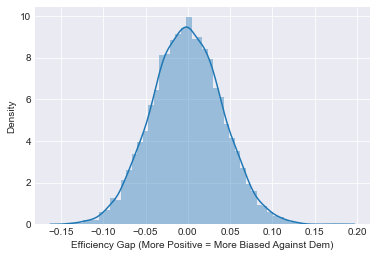

In [359]:
_ = sns.distplot(e_gap_values, axlabel="Efficiency Gap (More Positive = More Biased Against Dem)")


C:\Users\dpale\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


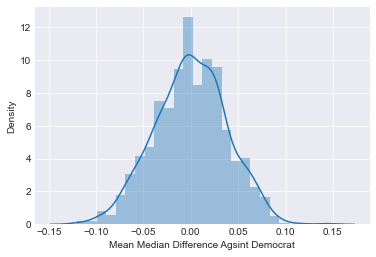

In [360]:
_ = sns.distplot(mm_diff_against_dem, axlabel="Mean Median Difference Agsint Democrat")

C:\Users\dpale\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


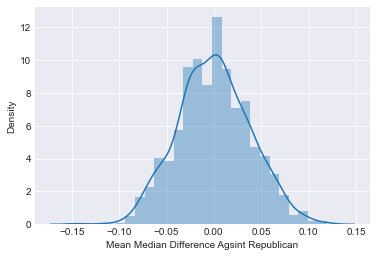

In [361]:
_ = sns.distplot(mm_diff_against_rep, axlabel="Mean Median Difference Agsint Republican")

[Text(0.5, 0, 'Partisan Bias Against Democrat')]

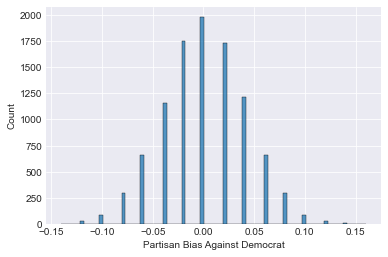

In [372]:
ax = sns.histplot(pb_against_dem)
ax.set(xlabel="Partisan Bias Against Democrat")

[Text(0.5, 0, 'Partisan Bias Against Republican')]

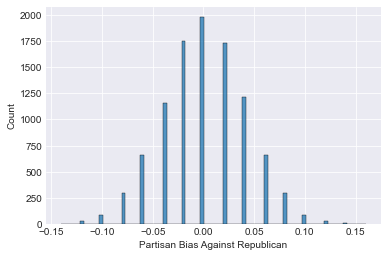

In [373]:
ax = sns.histplot(pb_against_dem, label="Partisan Bias Against Republican")
ax.set(xlabel="Partisan Bias Against Republican")

In [299]:
# Get efficiency gap means and stds for election simulations
# for states between 3 and 60 districts
e_gap_std = []
e_gap_mean = []

mm_diff_std_dem = []
mm_diff_mean_dem = []

pb_against_dem_std = []
pb_against_dem_mean = []

aggregated_metrics_std = []
aggregated_metrics_mean = []

for i in range(3, 60):
    e_gap_simulated, mm_diff_against_dem, mm_diff_against_rep, pb_dem, pb_rep = simulate_elections(i, 10000, 1000)
    e_gap_std.append(np.std(e_gap_simulated))
    e_gap_mean.append(np.mean(e_gap_simulated))
    mm_diff_mean_dem.append(np.mean(mm_diff_against_dem))
    mm_diff_std_dem.append(np.std(mm_diff_against_dem))
    pb_against_dem_std.append(np.std(pb_dem))
    pb_against_dem_mean.append(np.mean(pb_dem))
    mean_of_metrics = np.mean([e_gap_simulated, mm_diff_against_dem, pb_dem], axis=0)
    aggregated_metrics_std.append(np.std(mean_of_metrics))
    aggregated_metrics_mean.append(np.mean(mean_of_metrics))


In [99]:
vote_counts_bystate_sorted = vote_counts_bystate.sort_values(by="num_districts")

# Hypothesis Testing on Various Distributions - Efficiency Gap

After simulating ~1000 elections for district numbers ranging from 3 to 60, we can see that the number of districts affects the distribution of the efficiency gap. This can be seen by looking at the top, middle, and bottom lines on this chart. The x axis on this graph is the number of districts, and the y axis is the efficiency gap value. We can see that the distribution narrows as we increase the number of districts, so we take this into account when we compare a state's efficiency gap against the distribution in a hypothesis test.

The top line in this graph is  mean + 2 * std of the efficiency gap. The bottom line is mean - 2 * std, and the middle line is the mean which we can see consistently staying around 0.

A positive efficiency gap value in our calculation indicates a gerrymander against the democratic party, and a negative value indicates a gerrymander against the republican party.

By visually plotting efficiency gap values for each state, we visually see where the states fall on a hypothesis test with a significance level of 5%.

According to the efficiency gap, gerrymandered states against the democratic party in 2018 were Indiana, North Carolina, Ohio, and Texas. Gerrymandered states against the republican party in 2018 were Connecticut and New Jersey with California and Iowa sitting on the fringe.

Text(0.5, 1.0, 'Efficiency Gap State Scores And 95% Confidence Interval')

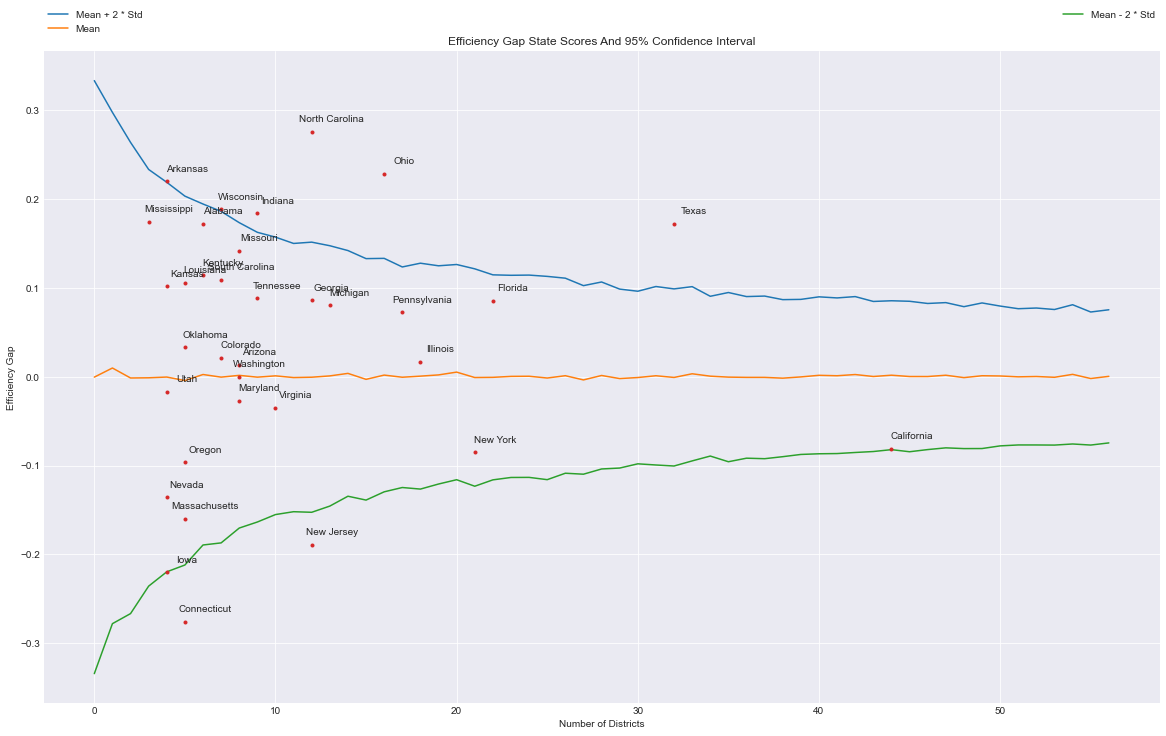

In [342]:
# Plot means and stds with increasing number of districts for efficiency gap
e_gap_mean = np.array(e_gap_mean)
e_gap_std = np.array(e_gap_std)

fig = plt.gcf()
fig.set_size_inches(20, 12)

plt.plot(e_gap_mean + 2 * e_gap_std, label="Mean + 2 * Std")
plt.plot(e_gap_mean, label="Mean")
plt.plot(e_gap_mean - 2 * e_gap_std, label="Mean - 2 * Std")
plt.plot(vote_counts_bystate_sorted["num_districts"], vote_counts_bystate_sorted["e_gap"],
         linestyle="none",
        marker=".")

for x, y, label in zip(vote_counts_bystate_sorted["num_districts"], 
                       vote_counts_bystate_sorted["e_gap"],
                        vote_counts_bystate_sorted.index):
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Number of Districts')
plt.ylabel('Efficiency Gap')
plt.title("Efficiency Gap State Scores And 95% Confidence Interval")



## Mean-Median Overview

The mean-median difference is a party’s median vote share minus its mean vote share, across all of a plan’s districts. For example, if a party has a median vote share of 45% and a mean vote share of 50%, then the plan has a mean-median difference of 5% against this party. When the mean and the median diverge significantly, the district distribution is skewed in favor of one party and against its opponent. Conversely, when the mean and the median are close, the district distribution is more symmetric.

Mean-Median difference essentially gives us a measure of skewness over a party's vote shares across its districts.

A large mean-median difference value for a party means that this party has a few districts that pull the mean away from the median. This is an indicator of packing, in which district lines pack voters of a party into a few districts to prevent them from winning races across the board in the state.

### Mean-Median Calculation

We derive two features from our vote count data to calculate the mean-median difference. These are labelled "dem_mm_diff" and "rep_mm_diff". This is done by first calculating the percent vote share for the two parties in their districts. For each state, we then average the vote shares for the two parties and get their medians. Finally, we difference the two (again, for each party) and this value is our mean-median difference value for the party.

A high dem_mm_diff value indicates that the democratic party is a victim of packing. Converesely, a high rep_mm_diff value indicates the same for the republican party.

In [246]:
for state in vote_counts_bystate_sorted.index:
    dem_votes = vote_counts_bydistrict.loc[state, "dem_votes"]
    rep_votes = vote_counts_bydistrict.loc[state, "rep_votes"]
    mm_diff_against_dem, mm_diff_against_rep = get_mm(dem_votes, rep_votes)
    vote_counts_bystate_sorted.loc[state, "mm_diff_against_dem"] = mm_diff_against_dem
    vote_counts_bystate_sorted.loc[state, "mm_diff_against_rep"] = mm_diff_against_rep

Text(0.5, 1.0, 'Mean-Median Difference Scores and 95% Confidence Interval')

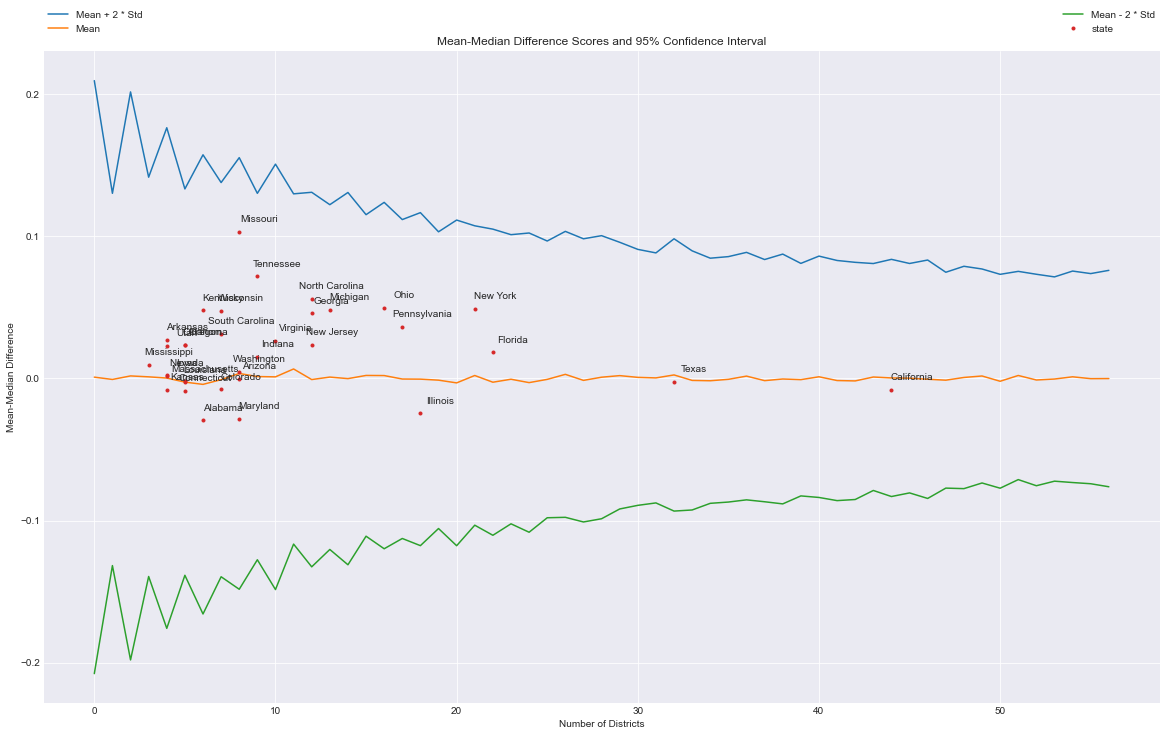

In [341]:
# Plot means and stds with increasing number of districts for mean/median difference
mm_diff_mean_dem = np.array(mm_diff_mean_dem)
mm_diff_std_dem = np.array(mm_diff_std_dem)

fig = plt.gcf()
fig.set_size_inches(20, 12)

plt.plot(mm_diff_mean_dem + 2 * mm_diff_std_dem, label="Mean + 2 * Std")
plt.plot(mm_diff_mean_dem, label="Mean")
plt.plot(mm_diff_mean_dem - 2 * mm_diff_std_dem, label="Mean - 2 * Std")


plt.plot(vote_counts_bystate_sorted["num_districts"], vote_counts_bystate_sorted["mm_diff_against_dem"],
         linestyle="none",
        marker=".", label="state")

for x, y, label in zip(vote_counts_bystate_sorted["num_districts"], 
                       vote_counts_bystate_sorted["mm_diff_against_dem"],
                        vote_counts_bystate_sorted.index):
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Number of Districts')
plt.ylabel('Mean-Median Difference')
plt.title("Mean-Median Difference Scores and 95% Confidence Interval")


# Partisan Bias

Partisan bias is another measure of gerrymandering. The partisan bias measurement uses the observed voting results and extrapolates them to create a hypothetical tied election. In this hypothetical tied election, we would expect both parties to receive 50% of congressional seats for their state. The partisan bias is the difference between the percentage of received seats by a party in this hypothetical election and 50%. A high value indicates that a party is receiving more seats than it "should" be given a tied election.

In [109]:
# First get the total vote difference.
# This number represents the number of votes above 50% a party received in a state.
def get_vote_diff(total_votes, total_votes_party, target_percent, districts):
    return ((total_votes_party / total_votes) - target_percent) * total_votes / districts

In [257]:
for state in vote_counts_bystate_sorted.index:
    dem_votes = vote_counts_bydistrict.loc[state, "dem_votes"]
    rep_votes = vote_counts_bydistrict.loc[state, "rep_votes"]
    partisan_bias_against_dem, partisan_bias_against_rep = get_pb(dem_votes, rep_votes)
    vote_counts_bystate_sorted.loc[state, "partisan_bias_against_dem"] = partisan_bias_against_dem
    vote_counts_bystate_sorted.loc[state, "partisan_bias_against_rep"] = partisan_bias_against_rep

Text(0.5, 1.0, 'Partisan Bias 95% Confidence Interval and State Scores')

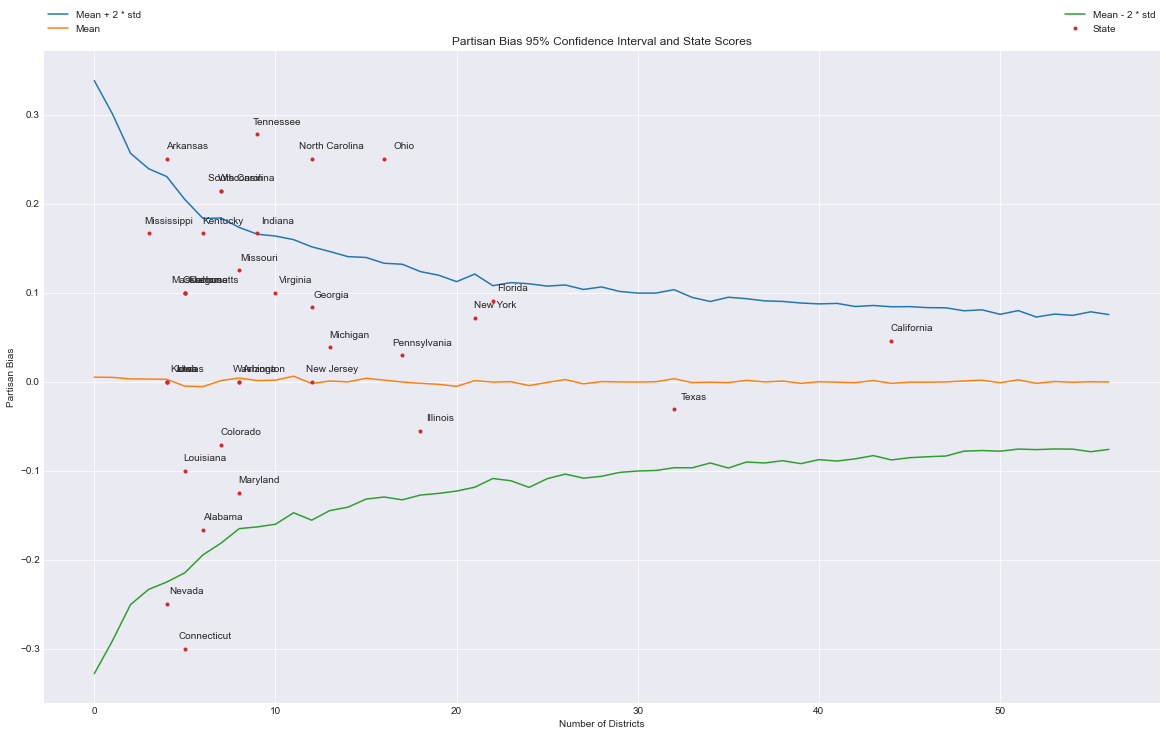

In [338]:
# Plot means and stds with increasing number of districts for mean/median difference
pb_against_dem_mean = np.array(pb_against_dem_mean)
pb_against_dem_std = np.array(pb_against_dem_std)

fig = plt.gcf()
fig.set_size_inches(20, 12)

plt.plot(pb_against_dem_mean + 2 * pb_against_dem_std, label="Mean + 2 * std")
plt.plot(pb_against_dem_mean, label="Mean")
plt.plot(pb_against_dem_mean - 2 * pb_against_dem_std, label="Mean - 2 * std")

plt.plot(vote_counts_bystate_sorted["num_districts"], vote_counts_bystate_sorted["partisan_bias_against_dem"],
         linestyle="none",
        marker=".", label="State")

for x, y, label in zip(vote_counts_bystate_sorted["num_districts"], 
                       vote_counts_bystate_sorted["partisan_bias_against_dem"],
                        vote_counts_bystate_sorted.index):
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Number of Districts')
plt.ylabel('Partisan Bias')
plt.title("Partisan Bias 95% Confidence Interval and State Scores")


In [307]:
metrics = vote_counts_bystate_sorted.loc[:,["partisan_bias_against_dem", "e_gap", "mm_diff_against_dem"]]
vote_counts_bystate_sorted["gerry_metrics_mean"] = metrics.mean(axis=1)

Text(0.5, 1.0, 'Mean of Gerrymandering Scores and 95% Interval By Number of Districts (e_gap, mean median, partisan bias)')

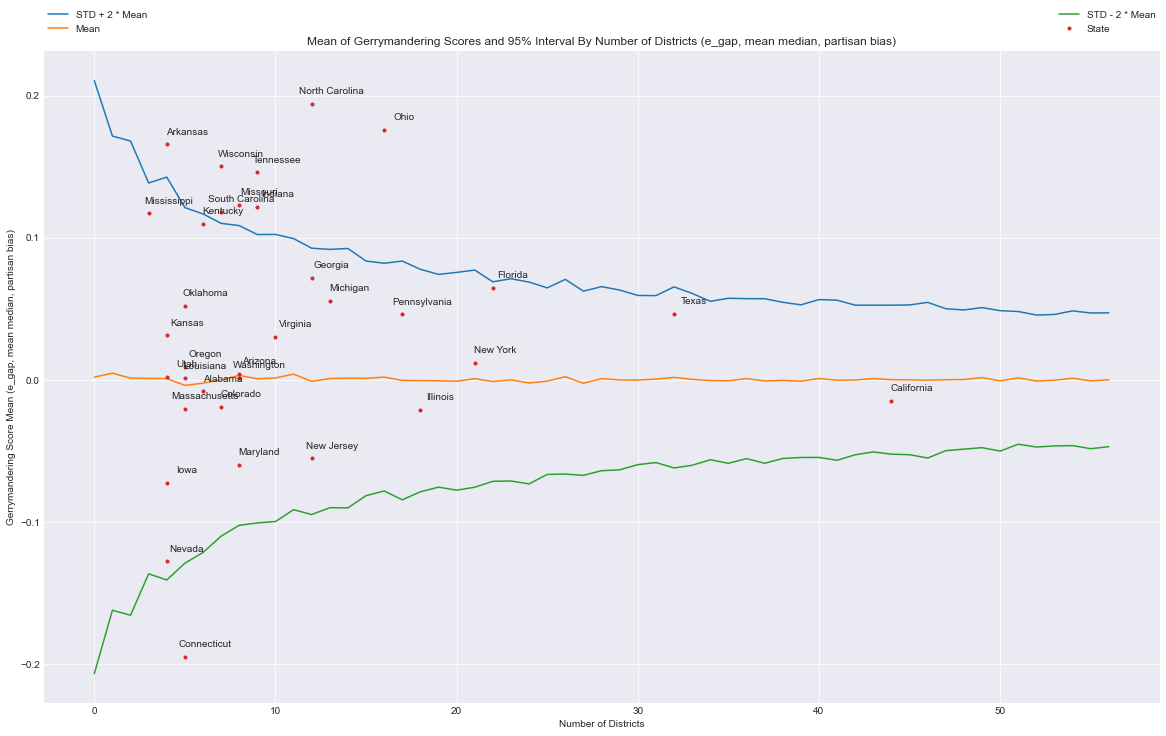

In [333]:
# Plot means and stds with increasing number of districts for mean/median difference
aggregated_metrics_mean = np.array(aggregated_metrics_mean)
aggregated_metrics_std = np.array(aggregated_metrics_std)

fig = plt.gcf()
fig.set_size_inches(20, 12)

plt.plot(aggregated_metrics_mean + 2 * aggregated_metrics_std, label="STD + 2 * Mean")
plt.plot(aggregated_metrics_mean, label="Mean")
plt.plot(aggregated_metrics_mean - 2 * aggregated_metrics_std, label="STD - 2 * Mean")

plt.plot(vote_counts_bystate_sorted["num_districts"], vote_counts_bystate_sorted["gerry_metrics_mean"],
         linestyle="none",
        marker=".", label="State")

for x, y, label in zip(vote_counts_bystate_sorted["num_districts"], 
                       vote_counts_bystate_sorted["gerry_metrics_mean"],
                        vote_counts_bystate_sorted.index):
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Number of Districts')
plt.ylabel('Gerrymandering Score Mean (e_gap, mean median, partisan bias)')
plt.title("Mean of Gerrymandering Scores and 95% Interval By Number of Districts (e_gap, mean median, partisan bias)")


## Examining Correlations

By looking at pairplots and correlations plots, we can see that our gerrymandering metrics are all postiively correlated. First we look at all metrics for and against both parties, and we see that a gerrymander against one party is negatively correlated with a gerrymander for another.

Since the gerrymandering metrics mirror each other--e.g. the gerrymandering score for one party exactly matchins the negative for another on a given state, we look at metrics that measure gerrymandering against democrat voters with the understanding that a positive value means a gerrymander against democrats, and a negative value means a gerrymander against republicans. 


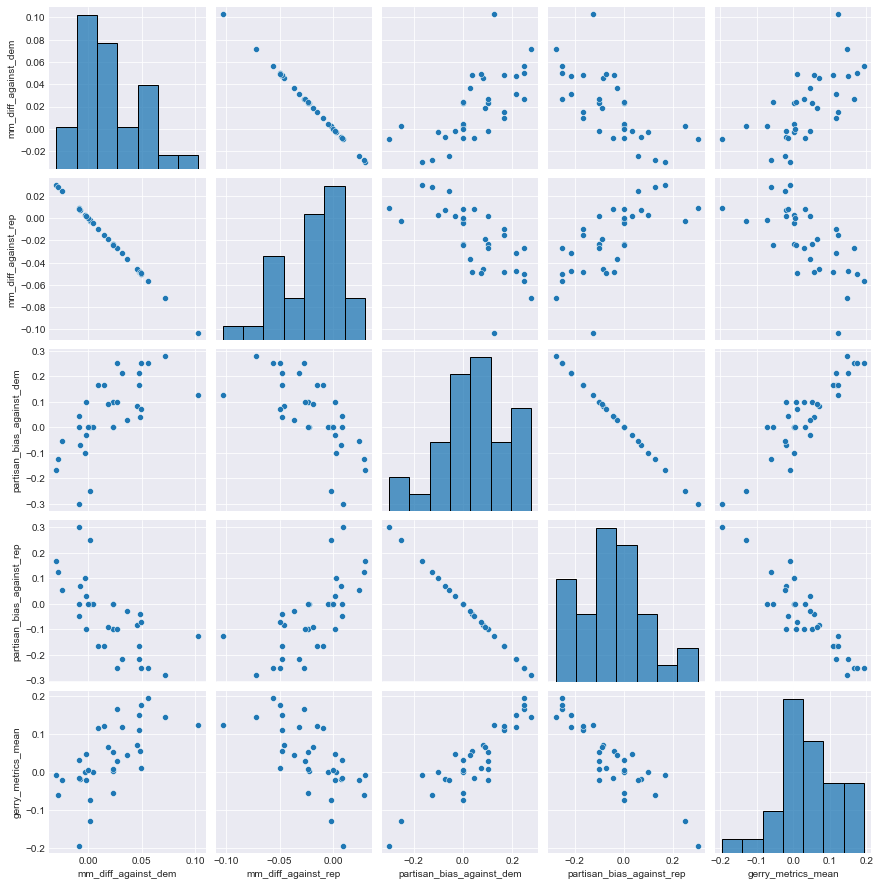

In [321]:
sns.pairplot(vote_counts_bystate_sorted.iloc[:,5:])

<AxesSubplot:>

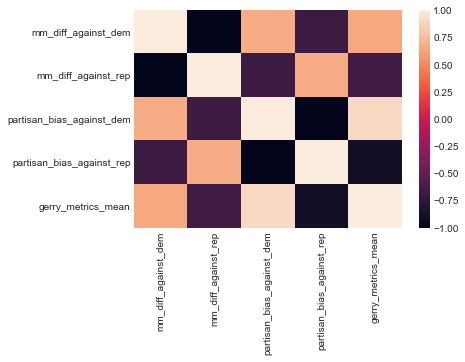

In [322]:
corr = vote_counts_bystate_sorted.iloc[:,5:].corr()
sns.heatmap(corr)

In [323]:
no_redundant_metrics = ["partisan_bias_against_dem", "e_gap", "mm_diff_against_dem", "gerry_metrics_mean"]


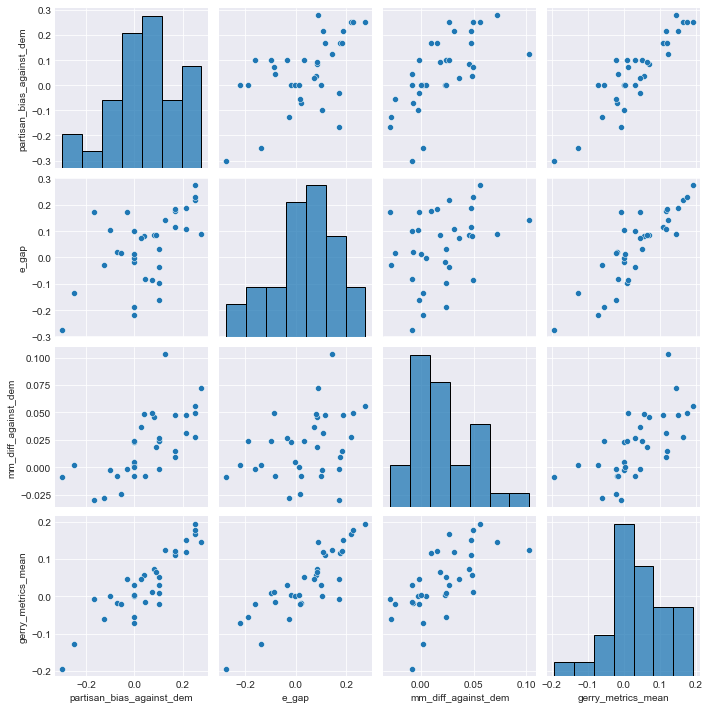

In [324]:
sns.pairplot(vote_counts_bystate_sorted.loc[:,no_redundant_metrics])

<AxesSubplot:>

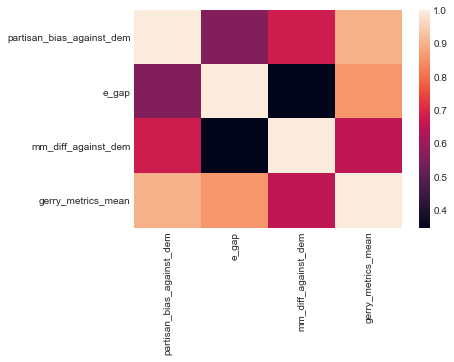

In [320]:
corr = vote_counts_bystate_sorted.loc[:,no_redundant_metrics].corr()
sns.heatmap(corr) 

# Plotting Distributions and Looking at Skewness 

By looking at the KDE plots for the gerrymandering scores we calculated for each state, we can see that the overall trend across the country is a negative skew. As we have seen from our election simulations and plotting the resulting distributions for them, we would expect our gerrymandering metrics to be normally distributed about the mean. Thus, this indicates that the country-wide trend is a gerrymander against democrats; i.e. the mode of all of our plots is observed to be above the mean.


In [346]:
# Skewness values
vote_counts_bystate_sorted.loc[:,no_redundant_metrics].skew(axis=0)

partisan_bias_against_dem   -0.527198
e_gap                       -0.511516
mm_diff_against_dem          0.576211
gerry_metrics_mean          -0.322645
dtype: float64

<AxesSubplot:xlabel='partisan_bias_against_dem', ylabel='Density'>

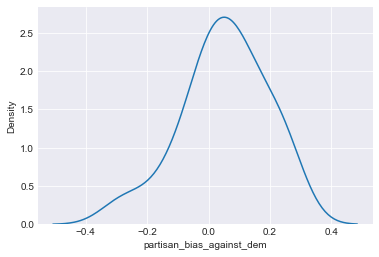

In [294]:
sns.kdeplot(vote_counts_bystate_sorted["partisan_bias_against_dem"])

<AxesSubplot:xlabel='e_gap', ylabel='Density'>

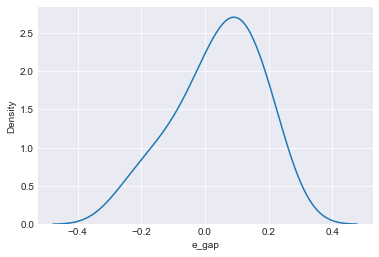

In [295]:
sns.kdeplot(vote_counts_bystate_sorted["e_gap"])

<AxesSubplot:xlabel='mm_diff_against_dem', ylabel='Density'>

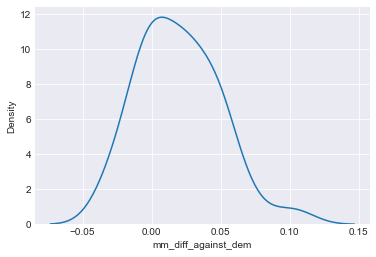

In [296]:
sns.kdeplot(vote_counts_bystate_sorted["mm_diff_against_dem"])

<AxesSubplot:xlabel='gerry_metrics_mean', ylabel='Density'>

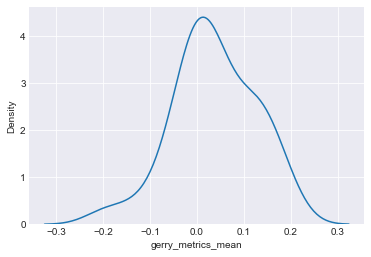

In [311]:
sns.kdeplot(vote_counts_bystate_sorted["gerry_metrics_mean"])

In [ ]:
# Run these cells to produce new CSV's for vote counts
vote_counts_bystate.to_csv("vote_counts_bystate.csv")
vote_counts.to_csv("vote_counts_bydistrict.csv")